In [3]:
from pendulum import Pendulum_2D
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import CubicSpline
from IPython.display import clear_output
import pickle
import os

In [13]:
y0 = np.array([np.pi/4, 0]) 
t0 = 0
m = 10
l = 10
tf = 100
time_step = 0.1


rk4 = Pendulum_2D(m, l) 
rk4.set_initial_condition(t0, y0, "canonical")
rk4.integrate("RK4", tf, "generalized", h = time_step)    
rk4.calculate_hamiltonian()

In [7]:
y0 = np.array([np.pi/4, 0]) 
t0 = 0
m = 10
l = 10
tf = 100
time_step = 0.1

benchmark = Pendulum_2D(m, l)
benchmark.set_initial_condition(t0, y0, "canonical")
benchmark.integrate("dop853", tf, "generalized", rtol = 1e-12, atol = 1e-12)

for i, time_step in enumerate(np.geomspace(0.0001, 1, 5)): 
    case = Pendulum_2D(m, l, ID = "special")
    case.set_initial_condition(t0, y0, "canonical") 
    case.integrate("RK4", tf, "canonical", h = time_step) 
    case.calculate_hamiltonian()
    
    with open(f"data/case_{i+15}.pkl", "wb") as f: 
        pickle.dump(case, f)

In [14]:
y0 = np.array([np.pi/4, 0]) 
t0 = 0
m = 10
l = 10
tf = 100
time_step = 0.1

cases = []

benchmark = Pendulum_2D(m, l)
benchmark.set_initial_condition(t0, y0, "canonical")
benchmark.integrate("dop853", tf, "generalized", rtol = 1e-12, atol = 1e-12)

for method in tqdm(['euler', 'leapfrog', "RK4"]):
    for time_step in tqdm(np.geomspace(0.0001, 1, 5), leave = False): 
        
        case = Pendulum_2D(m, l)
        case.set_initial_condition(t0, y0, "canonical") 
        
        if method == "RK4": 
            case.integrate(method, tf, "generalized", h = time_step) 
        else: 
            case.integrate(method, tf, "canonical", h = time_step) 

        cases.append(case) 
        clear_output(wait=True)
        
benchmark.calculate_hamiltonian()
for case in cases: 
    case.calculate_hamiltonian()


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:42<00:00, 14.00s/it]


In [16]:
import os
import pickle
cases = []

for file in os.listdir('data/'): 
    with open(f"data/{file}", "rb") as f:
        case = pickle.load(f)
        if case.ID != "special":
            cases.append(case)

In [17]:
for case in cases: 
    print(case.ID)

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


C:\Users\thoma\Anaconda3\envs\space_hnn\lib\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\thoma\Anaconda3\envs\space_hnn\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


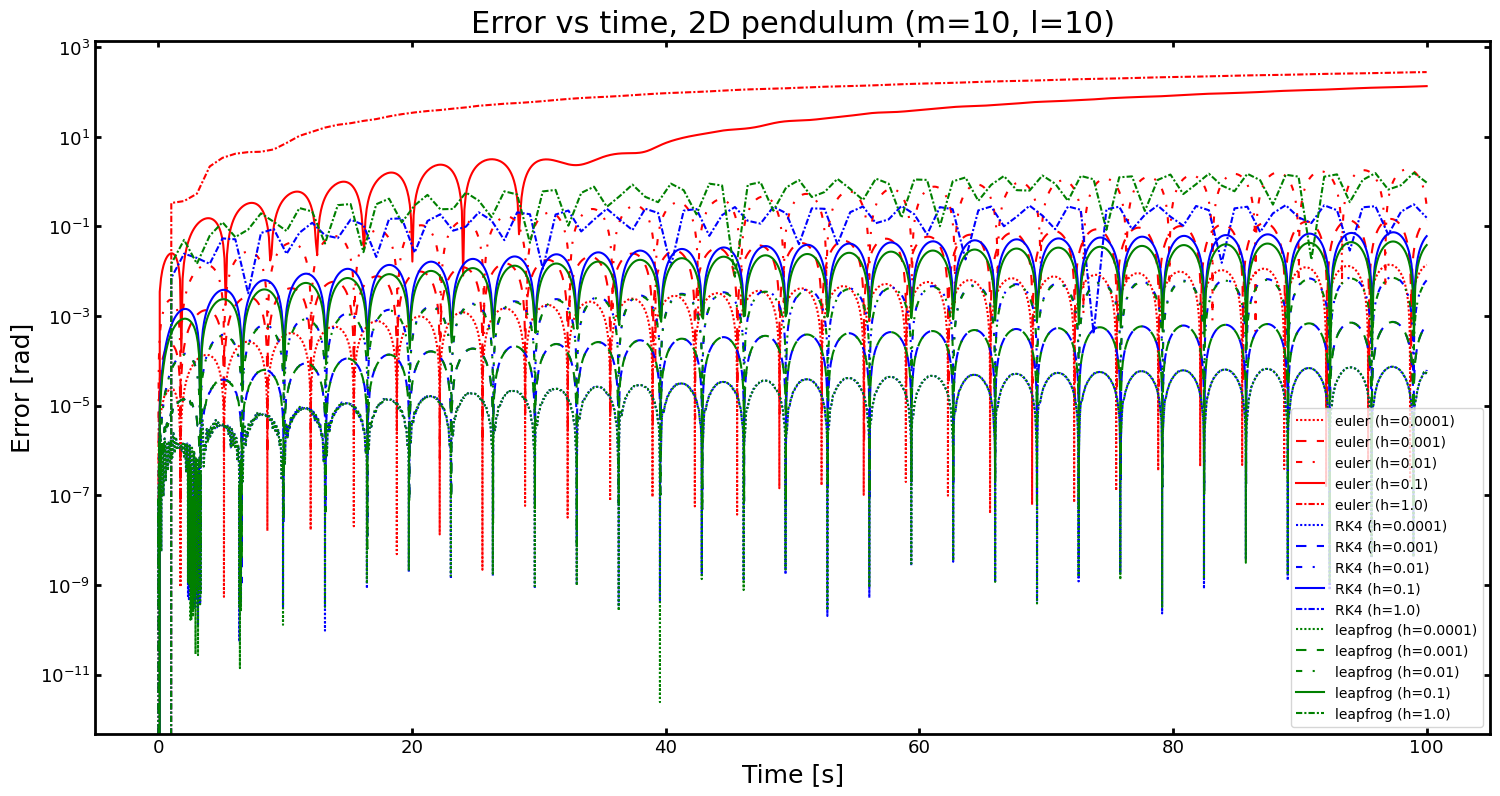

In [24]:
fig, ax = plt.subplots(1, 1, figsize = (18, 9)) 
styles = {"RK4": 'b', 
          "euler": 'r', 
          "leapfrog": 'm'}

dashes = {0.0001: (0, (1, 1)), 
          0.001: (0, (5, 5)), 
          0.01: (0, (3, 5, 1, 5)),
          0.1: None, 
          1: (0, (3, 1, 1, 1))}

for integrator in ["euler", "RK4", "leapfrog"]:
    for case in cases: 
        if case.integrator == integrator:
            ax.plot(case.states['canonical'][:,0], 
                         abs(case.states['canonical'][:,1] - cs(case.states['canonical'][:,0])),
                         color = colors[case.integrator], 
                         linestyle = dashes[case.time_step], 
                         label = f"{case.integrator} (h={case.time_step})")
    
ax.set_yscale("log")
ax.legend()
ax.set_title(f"Error vs time, 2D pendulum (m={cases[0].m}, l={cases[0].l})", fontsize = 22)
ax.set_xlabel("Time [s]", fontsize = 18)
ax.set_ylabel("Error [rad]", fontsize = 18) 

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(labelsize=13)
ax.tick_params(axis="both",direction="in",which="both", length=4, width = 2)
ax.tick_params(bottom=True, top=True, left=True, right=True)

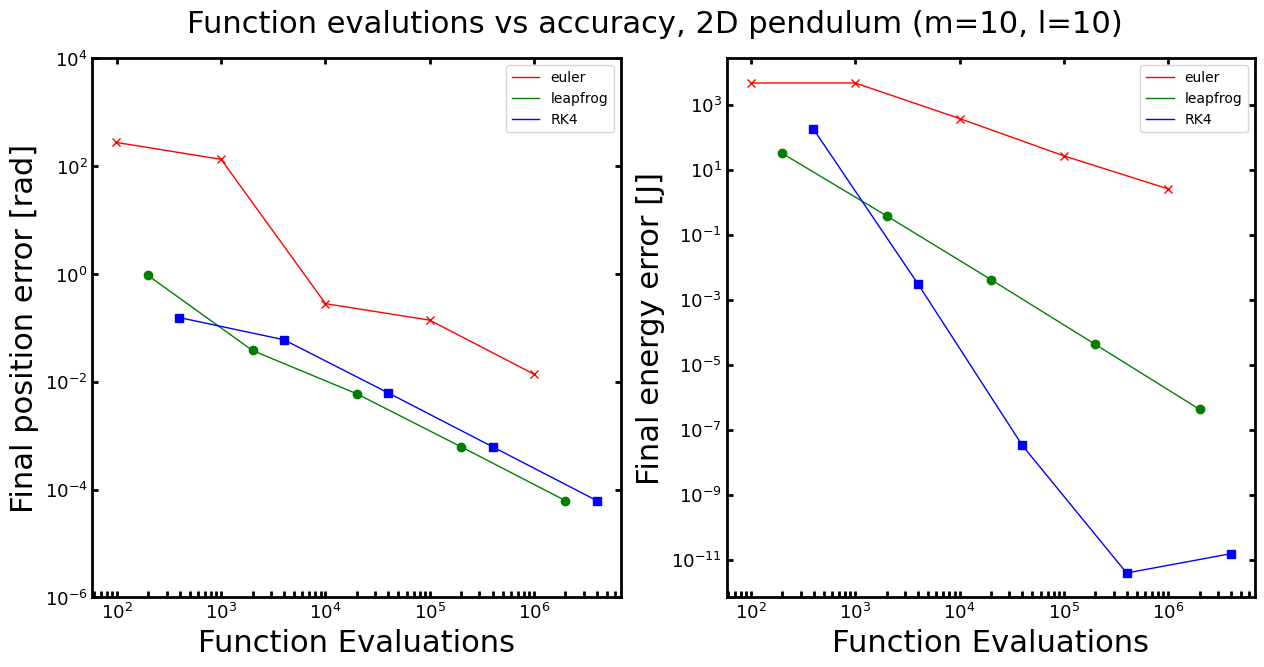

In [26]:
cs = CubicSpline(benchmark.states["generalized"][:,0], benchmark.states["generalized"][:,1])

fig, axes = plt.subplots(1, 2, figsize = (15, 7)) 
fig.suptitle(f"Function evalutions vs accuracy, 2D pendulum (m={cases[0].m}, l={cases[0].l})", fontsize = 22, y= 0.95)

colors = {"RK4": 'b',
          "euler": 'r', 
          "leapfrog": 'g'}
          
for case in cases: 
    
    if case.integrator == "euler":
        axes[0].plot(case.evals, abs(case.states['canonical'][-1,1] - cs(case.states['canonical'][-1,0])), 'x', color = colors[case.integrator]) 
        axes[1].plot(case.evals, abs(case.hamiltonian[-1] - case.hamiltonian[0]), 'x', color = colors[case.integrator])
        
    if case.integrator == "leapfrog":
        axes[0].plot(case.evals, abs(case.states['canonical'][-1,1] - cs(case.states['canonical'][-1,0])), 'o', color = colors[case.integrator]) 
        axes[1].plot(case.evals, abs(case.hamiltonian[-1] - case.hamiltonian[0]), 'o', color = colors[case.integrator])

    if case.integrator == "RK4":
        axes[0].plot(case.evals, abs(case.states['generalized'][-1,1] - cs(case.states['generalized'][-1,0])), 's', color = colors[case.integrator]) 
        axes[1].plot(case.evals, abs(case.hamiltonian[-1] - case.hamiltonian[0]), 's', color = colors[case.integrator])


for method in ['euler', 'leapfrog', "RK4"]: 
    
    X1 = []
    Y1 = []
    X2 = []
    Y2 = []
    
    for case in cases: 
        if case.integrator == method: 
                            
            X1.append(case.evals)
            Y1.append(abs(case.states['canonical'][-1,1] - cs(case.states['canonical'][-1,0])))
            
            X2.append(case.evals) 
            Y2.append(abs(case.hamiltonian[-1] - case.hamiltonian[0]))

            
    axes[0].plot(X1, Y1, linewidth = 1, label = method, color = colors[method]) 
    axes[1].plot(X2, Y2, linewidth = 1, label = method, color = colors[method]) 


axes[1].set_xscale("log") 
axes[1].set_yscale("log") 
axes[1].legend()
axes[1].set_xlabel("Function Evaluations", fontsize = 22)
axes[1].set_ylabel("Final energy error [J]", fontsize = 22)

axes[0].set_xscale("log") 
axes[0].set_yscale("log") 
axes[0].legend()
axes[0].set_ylim(1e-6, 1e4) 
# axes[0].set_xlim(10, 1e7)
axes[0].set_xlabel("Function Evaluations", fontsize = 22)
axes[0].set_ylabel("Final position error [rad]", fontsize = 22)

for ax in axes:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    ax.tick_params(labelsize=13)
    ax.tick_params(axis="both",direction="in",which="both", length=4, width = 2)
    ax.tick_params(bottom=True, top=True, left=True, right=True)


In [47]:
import pickle

for i, case in enumerate(cases): 
    with open(f'data/case_{i}.pkl', 'wb') as f:
        pickle.dump(case, f)